# EEG Alpha Decoding Curve Across Time Windows Using CSP and LDA

> **Note:** This script takes about 12 minutes to run. Hyperparamter: n_comp; channels aterior to FC were omitted due to potential bridging

This script evaluates how decoding accuracy from EEG alpha band power changes as a function of the temporal integration window. It combines Common Spatial Patterns (CSP) for feature extraction with Linear Discriminant Analysis (LDA) for classification, using cross-validation on data from multiple subjects.

---

## **1. Data Loading and Preprocessing**
- **Import and Directory Setup:**
  - Sets up the working directory and paths to the data, derivatives, analysis, and results directories.
  - Configures MNE to minimize log messages during execution.

- **Channel and Subject Specifications:**
  - A list of subjects and a full set of EEG channels (`picks_hubner`) are defined.
  - Channels deemed noisy for specific subjects (defined in `subjects_channel_reject`) are removed on a per-subject basis.

- **Signal Filtering and Artifact Removal:**
  - **Bandpass Filtering:**  
    A Butterworth filter (8–12 Hz) is applied to isolate the alpha band using the `bandpass_filter` function.
  - **Edge Artifact Removal:**  
    The script removes the first and last 120 samples of the signal to avoid filter-induced artifacts.
  - **Feature Extraction:**  
    The `compute_average_hilbert_amplitude` function computes the log-transformed mean amplitude over time using the Hilbert transform. This provides a compact measure of alpha power per trial and channel.

---

## **2. Decoding Pipeline with CSP and LDA**
- **Time Window Integration:**
  - The script tests multiple integration windows defined by the variable `amount_integrated_time` (ranging from 5 to 80 in steps, interpreted as multiples of 30 ms).
  - For each window, only a portion of the time samples (i.e., the first `int(30 * window)` samples) of the preprocessed data is used. This tests how the integration period affects decoding performance.

- **CSP for Feature Extraction:**
  - **Initialization:**  
    A CSP object is created with a specified number of components (`n_comp = 6`) to transform the EEG data into a spatial feature space that maximizes variance differences between the conditions.
  - **Application:**  
    The CSP transformation is applied separately on the training and testing sets within the cross-validation loop.

- **Classification with LDA:**
  - **Model Setup:**  
    LDA is initialized with a covariance estimator (Ledoit-Wolf regularization) to improve stability.
  - **Cross-Validation:**  
    For each integration window and subject, the data is split into four folds. For each fold:
    - CSP is fitted on the training data.
    - Both training and testing data are transformed using the fitted CSP.
    - Log-transformed Hilbert amplitude features are computed from the CSP-transformed data.
    - LDA is trained on the training features and then used to predict labels on the test set.
    - Accuracy is calculated for each fold.
  - **Result Aggregation:**  
    The average accuracy per subject for each time window is computed and then collected across all subjects.

---

## **3. Group-Level Analysis and Results Saving**
- **Results Calculation:**
  - For each integration window, the script computes:
    - **Group Mean Accuracy:** Mean of subject accuracies across all subjects contributing data.
    - **Standard Error:** Estimated as the standard deviation across subjects divided by the square root of the number of subjects.
  - These results (time window, mean accuracy, and standard error) are compiled into a structured NumPy array.

- **Storage:**
  - The final results are saved in the designated decoding results directory using NumPy's `.npy` format.

---

## **4. Purpose and Applications**
- **Objective:**  
  To assess the effect of computing the alpha band feature vector from virtual channels as craeted by CSP as opposed to using a sub-set of physical channels.


---

## **Execution Details**
- The script processes each subject's data file (if available), applies channel cleaning, filters the signal, and performs cross-validation using CSP and LDA.
- The process is repeated over multiple integration window sizes, accumulating performance metrics at the group level.
- The overall results are output as a NumPy array for easy further analysis or visualization.


In [1]:
import os
import numpy as np
from scipy.signal import butter, sosfilt, hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from os.path import join
import mne
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level('warning')

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")

In [2]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)

def compute_average_hilbert_amplitude(data):
    """
    Compute log-mean amplitude using Hilbert transform.
    """
    analytic = hilbert(data, axis=2)
    amplitude = np.abs(analytic)
    mean_amplitude = amplitude.mean(axis=2)
    return np.log(mean_amplitude)


In [3]:
# List of subjects and channels
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]
channel_dict = {
    'A1': 'Fp1', 'A2': 'AF7', 'A3': 'AF3', 'A4': 'F1', 'A5': 'F3', 'A6': 'F5', 'A7': 'F7', 'A8': 'FT7',
    'A9': 'FC5', 'A10': 'FC3', 'A11': 'FC1', 'A12': 'C1', 'A13': 'C3', 'A14': 'C5', 'A15': 'T7', 'A16': 'TP7',
    'A17': 'CP5', 'A18': 'CP3', 'A19': 'CP1', 'A20': 'P1', 'A21': 'P3', 'A22': 'P5', 'A23': 'P7', 'A24': 'P9',
    'A25': 'PO7', 'A26': 'PO3', 'A27': 'O1', 'A28': 'Iz', 'A29': 'Oz', 'A30': 'POz', 'A31': 'Pz', 'A32': 'CPz',
    'B1': 'Fpz', 'B2': 'Fp2', 'B3': 'AF8', 'B4': 'AF4', 'B5': 'AFz', 'B6': 'Fz', 'B7': 'F2', 'B8': 'F4',
    'B9': 'F6', 'B10': 'F8', 'B11': 'FT8', 'B12': 'FC6', 'B13': 'FC4', 'B14': 'FC2', 'B15': 'FCz', 'B16': 'Cz',
    'B17': 'C2', 'B18': 'C4', 'B19': 'C6', 'B20': 'T8', 'B21': 'TP8', 'B22': 'CP6', 'B23': 'CP4', 'B24': 'CP2',
    'B25': 'P2', 'B26': 'P4', 'B27': 'P6', 'B28': 'P8', 'B29': 'P10', 'B30': 'PO8', 'B31': 'PO4', 'B32': 'O2'
}
all_channels = [*channel_dict.values()]
subjects_channel_reject = {'VPpdia': ['POz', 'P2'],
                            'VPpdib': ['P2', 'FC1', 'CP2'],
                            'VPpdic': ['P2'], 
                            'VPpdid': ['P2'], 'VPpdie': ['P2'], 
                            'VPpdif': ['P2', 'POz'], 'VPpdig': ['P2'], 
                            'VPpdih': ['P2', 'C3'], 
                            'VPpdii': ['P2'], 
                            'VPpdij': ['P2', 'P10'], 
                            'VPpdik': ['P2'], 
                            'VPpdil': ['P2'], 
                            'VPpdim': [], 'VPpdin': ['P2', 'POz'], 
                            'VPpdio': [], 'VPpdip': [], 'VPpdiq': [], 
                            'VPpdir': [], 'VPpdis': [], 'VPpdit': [], 
                            'VPpdiu': ['P2'], 'VPpdiv': ['P2', 'PO4', 'P1', 'PO3'], 
                            'VPpdiw': ['P1', 'P3', 'POz', 'Pz', 'CPz'], 
                            'VPpdix': [], 'VPpdiy': [], 'VPpdiz': ['P1', 'PO3'], 
                            'VPpdiza': ['PO4'], 'VPpdizb': ['Fz'], 
                            'VPpdizc': ['P1', 'PO3', 'POz', 'Pz', 'P2', 'FC2']}


In [4]:
# -- Parameters -- 
n_comp = 6
bp_low  = 8
bp_high = 13
task = "covert"

# Define number of integrated epochs
amount_integrated_time = np.linspace(5, 80, 16, dtype=int)

# Here accumulate all accuracies (across subjects) per time window in a dictionary
#   key = window size
#   value = list of cross-validation accuracies from all subjects
results_array = {
    "subjects": {},       # Subject-specific results
    "mean_accuracies": {}, # Group-level mean accuracies
    "se_accuracies": {}   # Group-level standard errors
}

# Main processing loop
for subject in subjects:
    print(f'processing {subject}...')
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_64_ica.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Clean channels
    picks_clean = all_channels.copy()
    if subject in subjects_channel_reject:
        for channel in subjects_channel_reject[subject]:
            if channel in picks_clean:
                picks_clean.remove(channel)

    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs'].flatten()[0]  # Sampling frequency

    # Preprocess data

    selected_indices = [picks_clean.index(ch) for ch in all_channels if ch in picks_clean]
    X = X[:, selected_indices, :]  # Select relevant channels
    X = bandpass_filter(X, bp_low, bp_high, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts

    # Initialize results for this subject
    results_array["subjects"][subject] = {}

    # Cross-validation and decoding
    for window in amount_integrated_time:
        window_data = X[:, :, :int(30 * window)]
        fold_accuracies = []
        n_folds = 4
        n_trials = X.shape[0] // n_folds
        folds = np.repeat(np.arange(n_folds), n_trials)

        # CSP and LDA
        csp = CSP(n_components=n_comp, log=None,reg=0.01, transform_into='csp_space')
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

        for i_fold in range(n_folds):
            X_trn, y_trn = window_data[folds != i_fold], y[folds != i_fold]
            X_tst, y_tst = window_data[folds == i_fold], y[folds == i_fold]

            # Train CSP and LDA
            csp.fit(X_trn, y_trn)
            X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
            lda.fit(X_trn_csp, y_trn)

            X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
            y_pred = lda.predict(X_tst_csp)

            # Compute accuracy
            accuracy = accuracy_score(y_tst, y_pred)
            fold_accuracies.append(accuracy)

        subject_mean_accuracy = np.mean(fold_accuracies)

        # Log subject-specific results
        if window not in results_array["subjects"][subject]:
            results_array["subjects"][subject][window] = []
        results_array["subjects"][subject][window].append(subject_mean_accuracy)

# Compute group-level metrics
for window in sorted(amount_integrated_time):
    subject_accuracies = [
        np.mean(results_array["subjects"][subject][window]) 
        for subject in results_array["subjects"].keys() 
        if window in results_array["subjects"][subject]
    ]
    mean_accuracy = np.mean(subject_accuracies)
    se_accuracy = np.std(subject_accuracies) / np.sqrt(len(subject_accuracies))
    results_array["mean_accuracies"][window] = mean_accuracy
    results_array["se_accuracies"][window] = se_accuracy


# Save group-level results
group_results = np.array(
    [(window, results_array["mean_accuracies"][window], results_array["se_accuracies"][window])
     for window in sorted(results_array["mean_accuracies"].keys())],
    dtype=[('time_window', '<i4'), ('mean_accuracy', '<f4'), ('standard_error', '<f4')]
)
        
np.save(join(decoding_results_dir, f"{task}_lda_alpha_{n_comp}-comp_CSP_decC_results_64_ica.npy"), group_results)

processing VPpdia...
processing VPpdib...
processing VPpdic...
processing VPpdid...
processing VPpdie...
processing VPpdif...
processing VPpdig...
processing VPpdih...
processing VPpdii...
processing VPpdij...
processing VPpdik...
processing VPpdil...
processing VPpdim...
processing VPpdin...
processing VPpdio...
processing VPpdip...
processing VPpdiq...
processing VPpdir...
processing VPpdis...
processing VPpdit...
processing VPpdiu...
processing VPpdiv...
processing VPpdiw...
processing VPpdix...
processing VPpdiy...
processing VPpdiz...
processing VPpdiza...
processing VPpdizb...
processing VPpdizc...


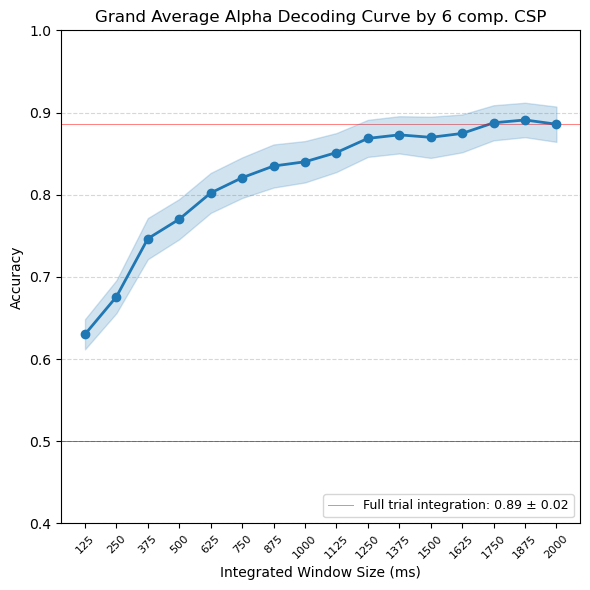

In [6]:
import matplotlib.pyplot as plt

# Extract fields
time_windows   = group_results['time_window']
mean_accuracies = group_results['mean_accuracy']
mean_ses        = group_results['standard_error']

# Sort the results
sort_idx       = np.argsort(time_windows)
time_windows   = time_windows[sort_idx] / 120 * 100 # convert to seconds
mean_accuracies = mean_accuracies[sort_idx]
mean_ses        = mean_ses[sort_idx]

# Inter stimlus interval of 30ms for fs=120
isi = 30
x_values = time_windows * isi
# Plot
plt.figure(figsize=(6, 6))
plt.plot(x_values, mean_accuracies, color='tab:blue', lw=2)
plt.scatter(x_values, mean_accuracies, color='tab:blue', zorder=3)
plt.fill_between(
    x_values, 
    mean_accuracies - mean_ses, 
    mean_accuracies + mean_ses, 
    color='tab:blue', alpha=0.2, zorder=3
)
plt.title(f'Grand Average Alpha Decoding Curve by {n_comp} comp. CSP', fontsize=12)
plt.xlabel('Integrated Window Size (ms)', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.ylim(0.4, 1.0)
plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.xticks(x_values, fontsize=8, rotation=45)
plt.axhline(0.5, color='k', linestyle='-', alpha=0.5, linewidth=0.7, label='')
plt.axhline(y=1.0, color='k', linestyle='--', linewidth=0.7)
plt.axhline(mean_accuracies[-1], color='red', linestyle='-', linewidth=0.7, 
            label=f'Full trial integration: {mean_accuracies[-1]:.2f} ± {mean_ses[-1]:.2f}',
            alpha=0.5)
plt.legend(fontsize=9, loc='lower right')
plt.grid(alpha=0.5, linestyle='--', axis = 'y')
plt.tight_layout()
#plt.savefig(join(plots_dir, f'{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.png'), dpi=300)
#plt.savefig(join(plots_dir, f'{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.svg'), dpi=300)
plt.show()
